<center style='color:red'><h3>TP1 - Détection d'anomalies</h3></center>

**Université Claude Bernard Lyon 1 - M2 IA -  Techniques d'apprentissage automatique**<br/>

**Par : Mohamed Massamba SENE**

#### Import des bibliothèques

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from scripts.anomaly import compare_models_anomaly
from scripts.novelty import compare_models_novelty
import missingno as msno
import ppscore as pps
import seaborn as sns
np.set_printoptions(threshold=10000, suppress=True)
warnings.filterwarnings('ignore')

#### Base de données Mouse

Télécharger et analyser le jeu de données

In [2]:
data = np.loadtxt("../data/mouse.txt")
print("Data Loaded ", data.shape)
data

Data Loaded  (500, 2)


array([[0.45660138, 0.43280641],
       [0.61137847, 0.5286246 ],
       [0.45029897, 0.71160612],
       [0.63901505, 0.46074398],
       [0.62895678, 0.32346951],
       [0.56621044, 0.28935773],
       [0.56765304, 0.29547266],
       [0.43602399, 0.41577573],
       [0.54541379, 0.36750178],
       [0.43945281, 0.54786743],
       [0.51220044, 0.50086465],
       [0.39175878, 0.6103473 ],
       [0.52185703, 0.57690608],
       [0.71941896, 0.43648094],
       [0.29953293, 0.62306273],
       [0.49822415, 0.42839984],
       [0.27405229, 0.48043206],
       [0.38284022, 0.54406889],
       [0.4249232 , 0.28482573],
       [0.52072382, 0.32542734],
       [0.44329558, 0.32697892],
       [0.39882122, 0.44917758],
       [0.50434998, 0.31104973],
       [0.64183164, 0.4463423 ],
       [0.38751391, 0.58357767],
       [0.39399361, 0.43554923],
       [0.53104101, 0.62956496],
       [0.68889681, 0.52416314],
       [0.64939623, 0.37410916],
       [0.46558805, 0.38082603],
       [0.

In [3]:
print("Outliers")
data[-10:]

Outliers


array([[0.29094998, 0.85576669],
       [0.7500676 , 0.89702766],
       [0.04055493, 0.50724008],
       [0.83516191, 0.13894039],
       [0.17474033, 0.36368611],
       [0.15150612, 0.87658566],
       [0.86030828, 0.6338334 ],
       [0.86208259, 0.59180538],
       [0.91602981, 0.52339059],
       [0.42732547, 0.83376657]])

In [4]:
print("Statistiques des instances normales")
normal_data = data[:-10]
print("Max:", np.min(normal_data, axis=0))
print("Min:", np.max(normal_data, axis=0))
print("Mean:", np.mean(normal_data, axis=0))
print("Std:", np.std(normal_data, axis=0))
print("Median:", np.median(normal_data, axis=0))
print("Correlation:", np.corrcoef(normal_data[:, 0], normal_data[:, 1])[0, 1])


print("\nStatistiques des outliers")
outliers = data[-10:]
print("Max:", np.min(normal_data, axis=0))
print("Min:", np.max(normal_data, axis=0))
print("Mean:", np.mean(normal_data, axis=0))
print("Std:", np.std(normal_data, axis=0))
print("Median:", np.median(normal_data, axis=0))
print("Correlation:", np.corrcoef(outliers[:, 0], outliers[:, 1])[0, 1])

Statistiques des instances normales
Max: [0.1459668  0.26330169]
Min: [0.85061873 0.8428794 ]
Mean: [0.50538242 0.59924674]
Std: [0.18766459 0.15458491]
Median: [0.50470158 0.62949395]
Correlation: -0.0470161834645587

Statistiques des outliers
Max: [0.1459668  0.26330169]
Min: [0.85061873 0.8428794 ]
Mean: [0.50538242 0.59924674]
Std: [0.18766459 0.15458491]
Median: [0.50470158 0.62949395]
Correlation: -0.2007056065115862


Les statistiques des instances normales montrent une distribution relativement équilibrée avec une faible corrélation négative entre `x1` et `x2` (-0.047), une moyenne proche de la médiane, et des écarts-types modérés (0.187 pour `x1` et 0.154 pour `x2`). En comparaison, les outliers présentent des statistiques similaires (moyennes, médianes et dispersions presque identiques), ce qui suggère que leurs valeurs absolues ne diffèrent pas de manière significative des données normales. Cependant, la corrélation pour les outliers (-0.201) est nettement plus négative, indiquant une relation inverse plus marquée entre `x1` et `x2` dans ce sous-ensemble. Cela suggère que les outliers se distinguent davantage par leur relation mutuelle ou leur position spatiale que par leurs valeurs individuelles.

Donner une représentation graphique des données

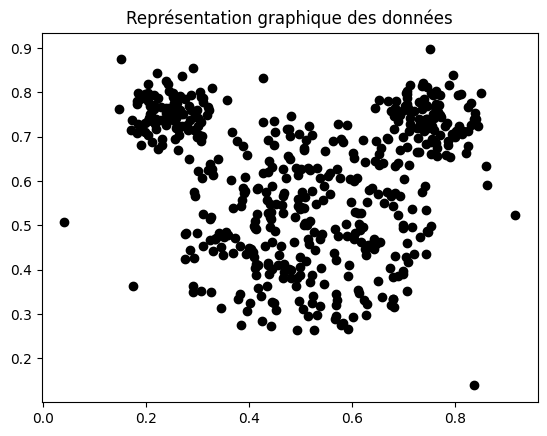

In [5]:
plt.scatter(data[:,0], data[:,1], color='black')
plt.title("Représentation graphique des données")
plt.show()

Appliquer la technique Isolation Forest pour détecter les outliers dans ce jeu de données

In [6]:
iso_forest = IsolationForest()
preds = iso_forest.fit_predict(data)
preds

array([ 1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
        1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1,
       -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
        1, -1,  1,  1,  1

In [7]:

print(f"Nombre d'outliers détecter: {(preds == -1).sum()}")

Nombre d'outliers détecter: 115


Appliquer la technique Local Outlier Factor pour détecter les outliers dans ce jeu de donner

In [8]:
lof = LocalOutlierFactor()
preds = lof.fit_predict(data)
preds

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [9]:
print(f"Nombre d'outliers détecter: {(preds == -1).sum()}")

Nombre d'outliers détecter: 10


Pour chacune des approches, proposer une approche pour mieux choisir le seuil de contamination

**Isolation Forest**

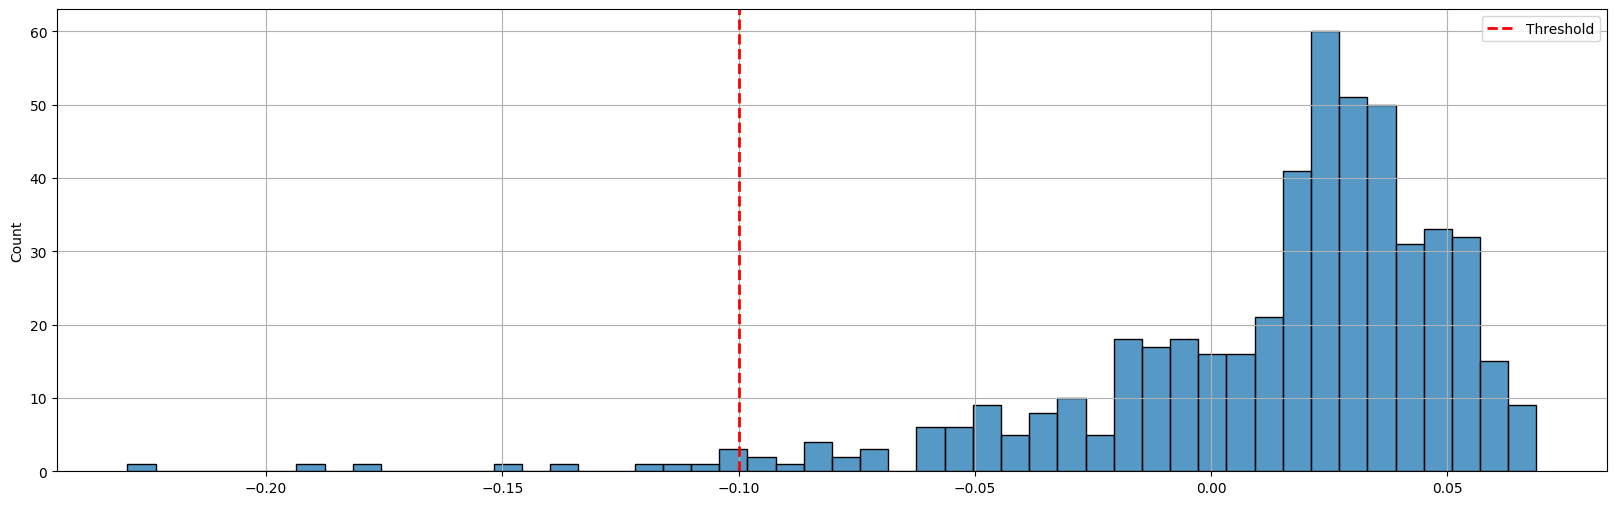

In [10]:
# Isolation Forest
iso = IsolationForest()
iso.fit(data)
iso_scores = iso.decision_function(data)

plt.figure(figsize=(20, 6))
sns.histplot(iso_scores, bins=50)
plt.axvline(x=-0.1, color='red', linestyle='--', linewidth=2, label=f"Threshold")
plt.legend()
plt.grid()
plt.show()

En visualisation l'histogramme nous jugeons que -0.10 pourrait être une bonne valeur pour les anomalies

In [11]:
outliers_data_iso = data[iso_scores <= -0.1]

**LocalOutlierFactor**

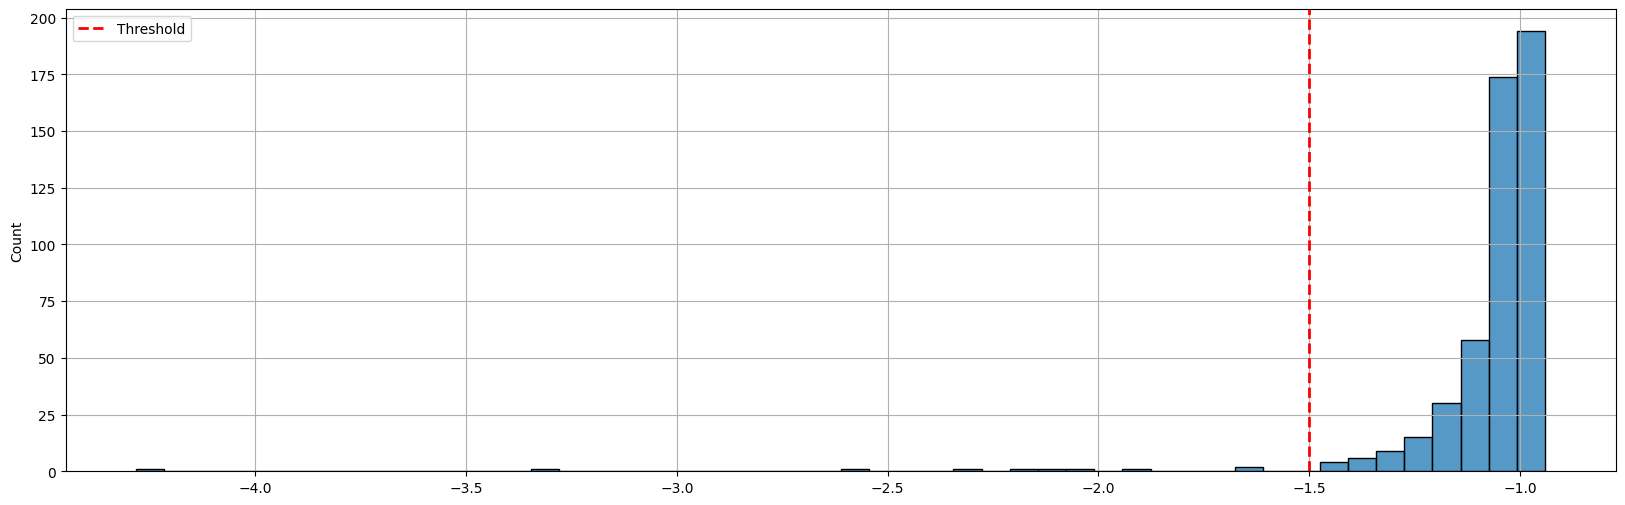

In [12]:
# LocalOutlierFactor
lof = LocalOutlierFactor()
lof.fit(data)
lof_factor = lof.negative_outlier_factor_

plt.figure(figsize=(20, 6))
sns.histplot(lof_factor, bins=50)
plt.axvline(x=-1.5, color='red', linestyle='--', linewidth=2, label=f"Threshold")
plt.legend()
plt.grid()
plt.show()

En visualisation l'histogramme nous jugeons que -1.5 pourrait être une bonne valeur pour les anomalies

In [13]:
outliers_data_lof = data[lof_factor <= -1.5]

Modifier votre représentation graphique précédente pour visualiser les données aberrantes avec les deux approches

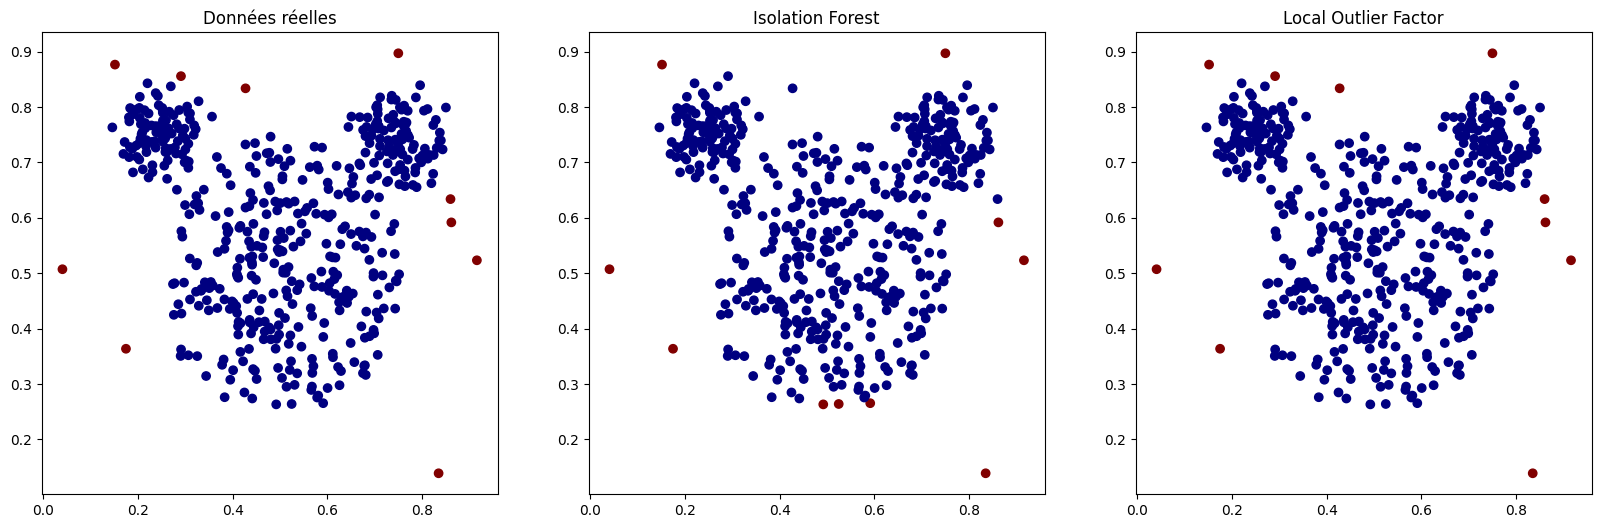

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

preds_iso = iso.fit_predict(data)
preds_lof = iso.fit_predict(data)

axes[0].scatter(data[:,0], data[:,1], c=[e in data[-10:] for e in data], cmap='jet')
axes[0].set_title("Données réelles")

axes[1].scatter(data[:,0], data[:,1], c=[True if row in outliers_data_iso else False for row in data], cmap='jet')
axes[1].set_title(f"Isolation Forest")

axes[2].scatter(data[:,0], data[:,1], c=[True if row in outliers_data_lof else False for row in data], cmap='jet')
axes[2].set_title(f"Local Outlier Factor")

plt.show()

**Comparaison des résultats obtenus**

Isolation Forest semble plus agressif en marquant des anomalies supplémentaires, tandis que LOF est plus fidèle aux anomalies réelles en se concentrant sur les points véritablement isolés. Les deux méthodes détectent globalement les anomalies périphériques, mais LOF offre une détection plus précise dans des environnements de forte densité

#### Jeu de données cartes de crédits

Préparer le jeu de données

In [15]:
credit_df = pd.read_csv("../data/creditcard.csv")
credit_df.drop(columns="Time", inplace=True)
credit_df.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


<AxesSubplot:>

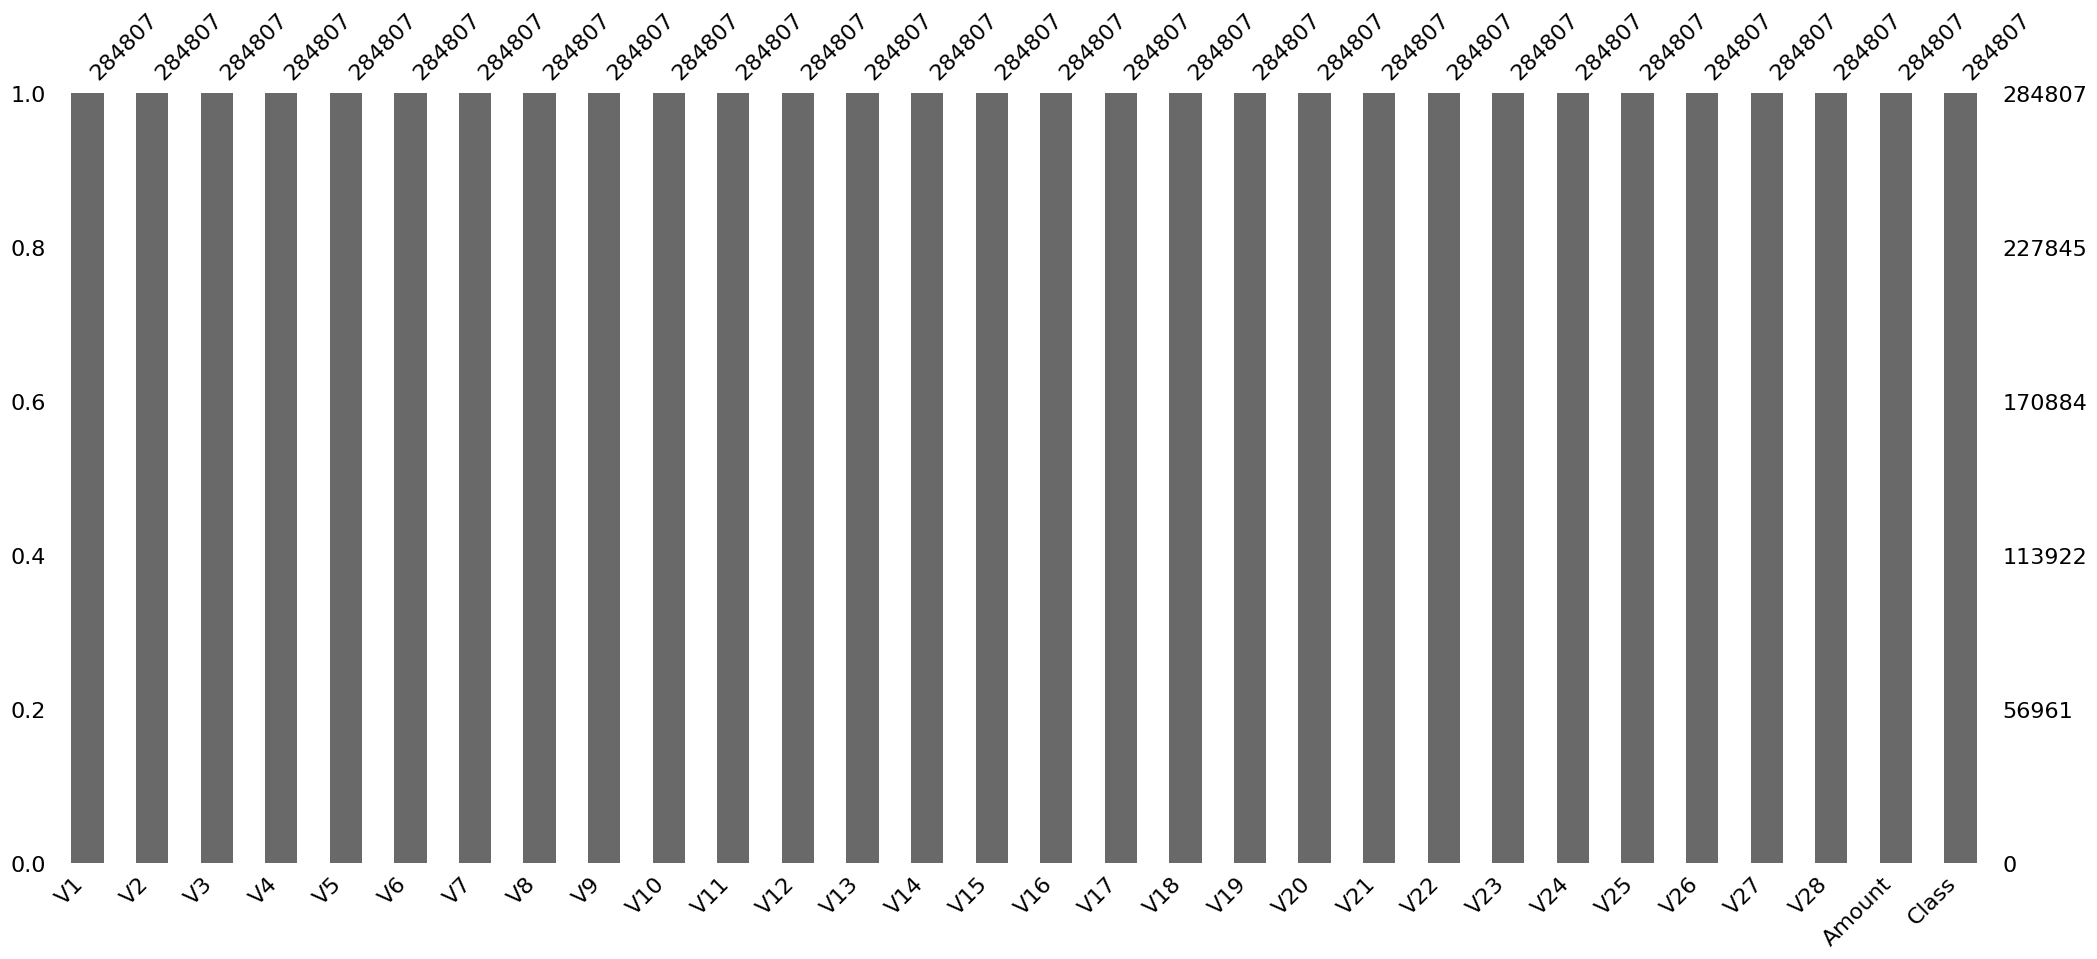

In [16]:
# Vérification des valeurs nulles
msno.bar(credit_df, p=0.8, filter="top")

In [17]:
# Suppression des duplicatats
print(credit_df.shape)
credit_df.drop_duplicates(inplace=True)
print(credit_df.shape)

(284807, 30)
(275663, 30)


In [18]:
# Vérification du nombre de valeurs uniques
credit_df.nunique()

V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

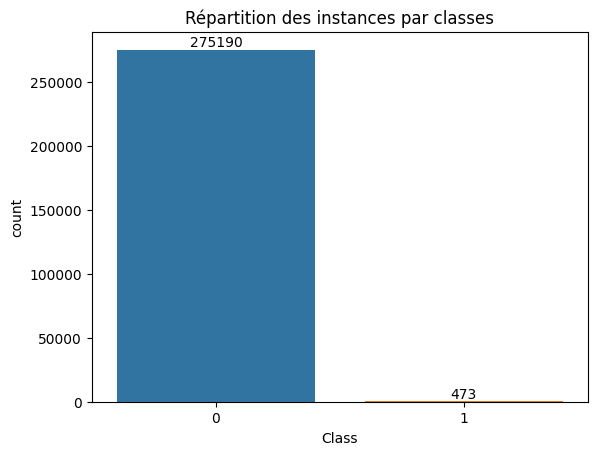

In [19]:
# Affichage de la répartition
ax = sns.countplot(data=credit_df, x="Class")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), textcoords='offset points')

plt.title("Répartition des instances par classes")
plt.show()

In [20]:
# Sélection des features en fonction de leur pouvoir predictif
credit_df["Class"] = credit_df["Class"].astype("category")
pps_predictors = pps.predictors(credit_df, y="Class")
pps_predictors

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,V14,Class,0.260346,classification,True,weighted F1,0.996701,0.997560,DecisionTreeClassifier()
1,V17,Class,0.196529,classification,True,weighted F1,0.996701,0.997350,DecisionTreeClassifier()
2,V10,Class,0.139309,classification,True,weighted F1,0.996701,0.997161,DecisionTreeClassifier()
3,V12,Class,0.078571,classification,True,weighted F1,0.996701,0.996960,DecisionTreeClassifier()
4,V7,Class,0.017955,classification,True,weighted F1,0.996701,0.996760,DecisionTreeClassifier()
5,V1,Class,0.000000,classification,True,weighted F1,0.996701,0.995499,DecisionTreeClassifier()
6,V2,Class,0.000000,classification,True,weighted F1,0.996701,0.996667,DecisionTreeClassifier()
7,V3,Class,0.000000,classification,True,weighted F1,0.996701,0.996561,DecisionTreeClassifier()
8,V4,Class,0.000000,classification,True,weighted F1,0.996701,0.996133,DecisionTreeClassifier()
9,V5,Class,0.000000,classification,True,weighted F1,0.996701,0.995971,DecisionTreeClassifier()


In [21]:
# Ne conserver que les features à ppscore relevant
features = pps_predictors.loc[pps_predictors.ppscore >= 0.01]
selected_feats = features.x.to_list()
selected_feats.append("Class")
selected_feats

['V14', 'V17', 'V10', 'V12', 'V7', 'Class']

In [22]:
# Création du dataframe final
final_df = credit_df[selected_feats]
final_df

,V14,V17,V10,V12,V7,Class
0,-0.311169,0.207971,0.090794,-0.617801,0.239599,0
1,-0.143772,-0.114805,-0.166974,1.065235,-0.078803,0
2,-0.165946,1.109969,0.207643,0.066084,0.791461,0
3,-0.287924,-0.684093,-0.054952,0.178228,0.237609,0
4,-1.119670,-0.237033,0.753074,0.538196,0.592941,0
...,...,...,...,...,...,...
284802,4.626942,1.991691,4.356170,2.711941,-4.918215,0
284803,-0.675143,-0.025693,-0.975926,0.915802,0.024330,0
284804,-0.510602,0.313502,-0.484782,0.063119,-0.296827,0
284805,0.449624,0.509928,-0.399126,-0.962886,-0.686180,0


Proposer une méthodologie pour la détection d'outliers en comparant plusieurs approches entre elles

In [23]:
# Modèles à comparer
ESTIMATOR_PARAMS = {
    RandomForestClassifier.__name__: {
        "estimator": RandomForestClassifier,
        "params": {
            "n_estimators": [10, 50, 100, 150],
            "max_depth": [5, 10, 15],
            "min_samples_split": np.linspace(2, 10, 5, dtype=int).tolist(),
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": False,
        "oversampling": False
    },
    DecisionTreeClassifier.__name__: {
        "estimator": DecisionTreeClassifier,
        "params": {
            "max_depth": [3, 5, 10],
            "min_samples_split": np.linspace(2, 10, 5, dtype=int).tolist(),
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": False,
        "oversampling": False
    },
    IsolationForest.__name__: {
        "estimator": IsolationForest,
        "params": {
            "n_estimators": [100, 150, 200],
            "contamination": np.linspace(0.01, 0.1, 10).tolist(),
            "max_samples": [0.8, 0.9, 1.0],
            "random_state": [42]
        },
        "is_supervised": False,
        "undersampling": False,
        "oversampling": False
    },
    LocalOutlierFactor.__name__: {
        "estimator": LocalOutlierFactor,
        "params": {
            "n_neighbors": [5, 10, 20, 30],
            "contamination": np.linspace(0.01, 0.1, 10).tolist(),
            "metric": ['euclidean', 'manhattan']
        },
        "is_supervised": False,
        "undersampling": False,
        "oversampling": False
    },
    HistGradientBoostingClassifier.__name__: {
        "estimator": HistGradientBoostingClassifier,
        "params": {
            "max_iter": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 4, 5],
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "class_weight": ['balanced'],
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": False,
        "oversampling": False
    },
    RandomForestClassifier.__name__ + "_undersampled": {
        "estimator": RandomForestClassifier,
        "params": {
            "n_estimators": [10, 50, 100, 150],
            "max_depth": [5, 10, 15],
            "min_samples_split": np.linspace(2, 10, 5, dtype=int).tolist(),
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": True,
        "oversampling": False
    },
    RandomForestClassifier.__name__ + "_oversampled": {
        "estimator": RandomForestClassifier,
        "params": {
            "n_estimators": [10, 50, 100, 150],
            "max_depth": [5, 10, 15],
            "min_samples_split": np.linspace(2, 10, 5, dtype=int).tolist(),
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": False,
        "oversampling": True
    },
}

Demarrage recherche hyperparametres pour RandomForestClassifier
Done! Meilleurs hyperparamètres pour RandomForestClassifier {'random_state': 42, 'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 10}
Performance du meilleur modele: RandomForestClassifier
Mean AUC ROC: 0.97
Mean AUC PR: 1.00
Mean F1 Score: 1.00
Mean Balanced Acc: 0.90
Demarrage recherche hyperparametres pour DecisionTreeClassifier
Done! Meilleurs hyperparamètres pour DecisionTreeClassifier {'random_state': 42, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_depth': 10}
Performance du meilleur modele: DecisionTreeClassifier
Mean AUC ROC: 0.90
Mean AUC PR: 1.00
Mean F1 Score: 1.00
Mean Balanced Acc: 0.88
Demarrage recherche hyperparametres pour IsolationForest
Done! Meilleurs hyperparamètres pour IsolationForest {'random_state': 42, 'n_estimators': 100, 'max_samples': 0.8, 'contamination': 0.01}
Performance du meilleur modele: IsolationForest
Mean AUC ROC: 0.97
Mean AUC PR: 1.00
Mean F1 Sc

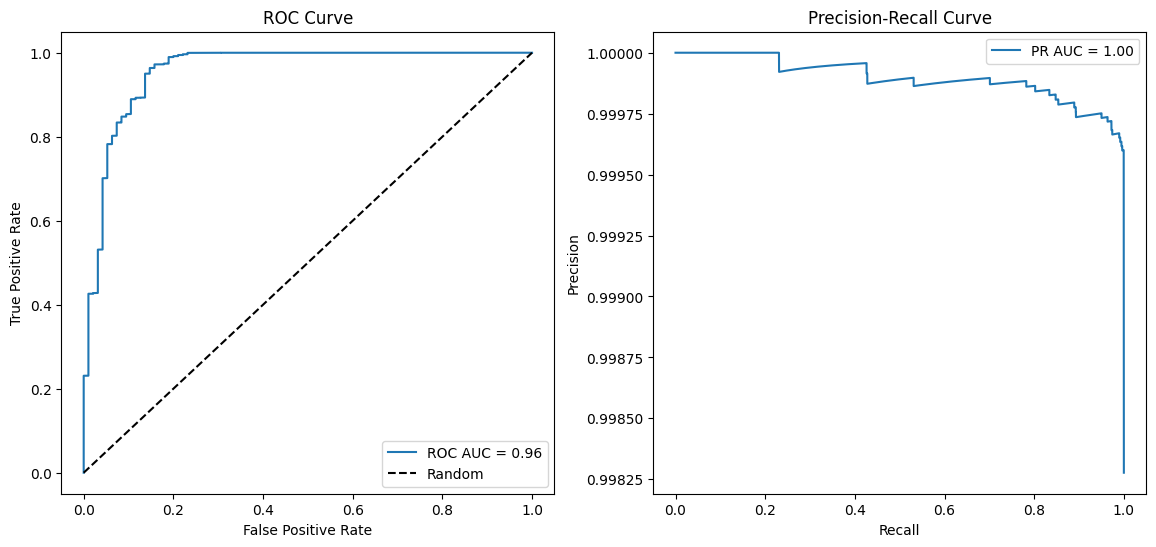

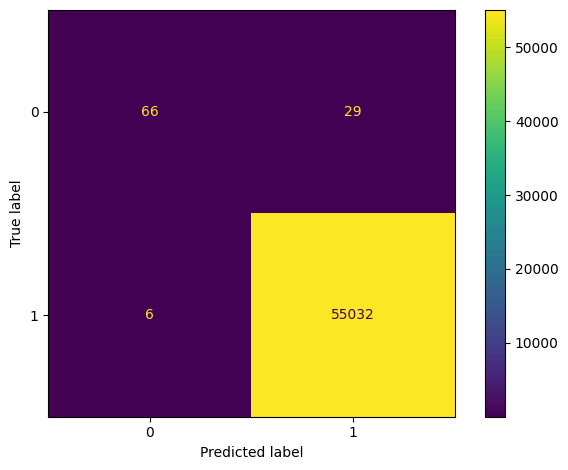

In [24]:
# Run de l'automatisation et résultats
compare_models_anomaly(final_df, 'Class', ESTIMATOR_PARAMS)

#### Jeu de données de détection d'intruisions dans les réseaux

Préparer les données

In [25]:
kcup_df = pd.read_csv("../data/KDDCup99.csv")
kcup_df.drop(columns="duration", inplace=True)
kcup_df.head(10)

,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,tcp,http,SF,181,5450,0,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal
1,tcp,http,SF,239,486,0,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal
2,tcp,http,SF,235,1337,0,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal
3,tcp,http,SF,219,1337,0,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal
4,tcp,http,SF,217,2032,0,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal
5,tcp,http,SF,217,2032,0,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal
6,tcp,http,SF,212,1940,0,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal
7,tcp,http,SF,159,4087,0,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal
8,tcp,http,SF,210,151,0,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal
9,tcp,http,SF,212,786,0,0,0,1,0,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal


In [26]:
kcup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   protocol_type                494020 non-null  object 
 1   service                      494020 non-null  object 
 2   flag                         494020 non-null  object 
 3   src_bytes                    494020 non-null  int64  
 4   dst_bytes                    494020 non-null  int64  
 5   land                         494020 non-null  int64  
 6   wrong_fragment               494020 non-null  int64  
 7   urgent                       494020 non-null  int64  
 8   hot                          494020 non-null  int64  
 9   num_failed_logins            494020 non-null  int64  
 10  logged_in                    494020 non-null  int64  
 11  lnum_compromised             494020 non-null  int64  
 12  lroot_shell                  494020 non-null  int64  
 13 

In [27]:
# Affichage des valeurs uniques
kcup_df.loc[:, kcup_df.nunique() == 2].columns

Index(['land', 'logged_in', 'lroot_shell', 'is_guest_login'], dtype='object')

In [28]:
# Conversion des colonnes en booléenes
columns_to_convert = ["land", "logged_in", "is_guest_login", ]
kcup_df[columns_to_convert] = kcup_df[columns_to_convert].astype(bool)
kcup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   protocol_type                494020 non-null  object 
 1   service                      494020 non-null  object 
 2   flag                         494020 non-null  object 
 3   src_bytes                    494020 non-null  int64  
 4   dst_bytes                    494020 non-null  int64  
 5   land                         494020 non-null  bool   
 6   wrong_fragment               494020 non-null  int64  
 7   urgent                       494020 non-null  int64  
 8   hot                          494020 non-null  int64  
 9   num_failed_logins            494020 non-null  int64  
 10  logged_in                    494020 non-null  bool   
 11  lnum_compromised             494020 non-null  int64  
 12  lroot_shell                  494020 non-null  int64  
 13 

<AxesSubplot:>

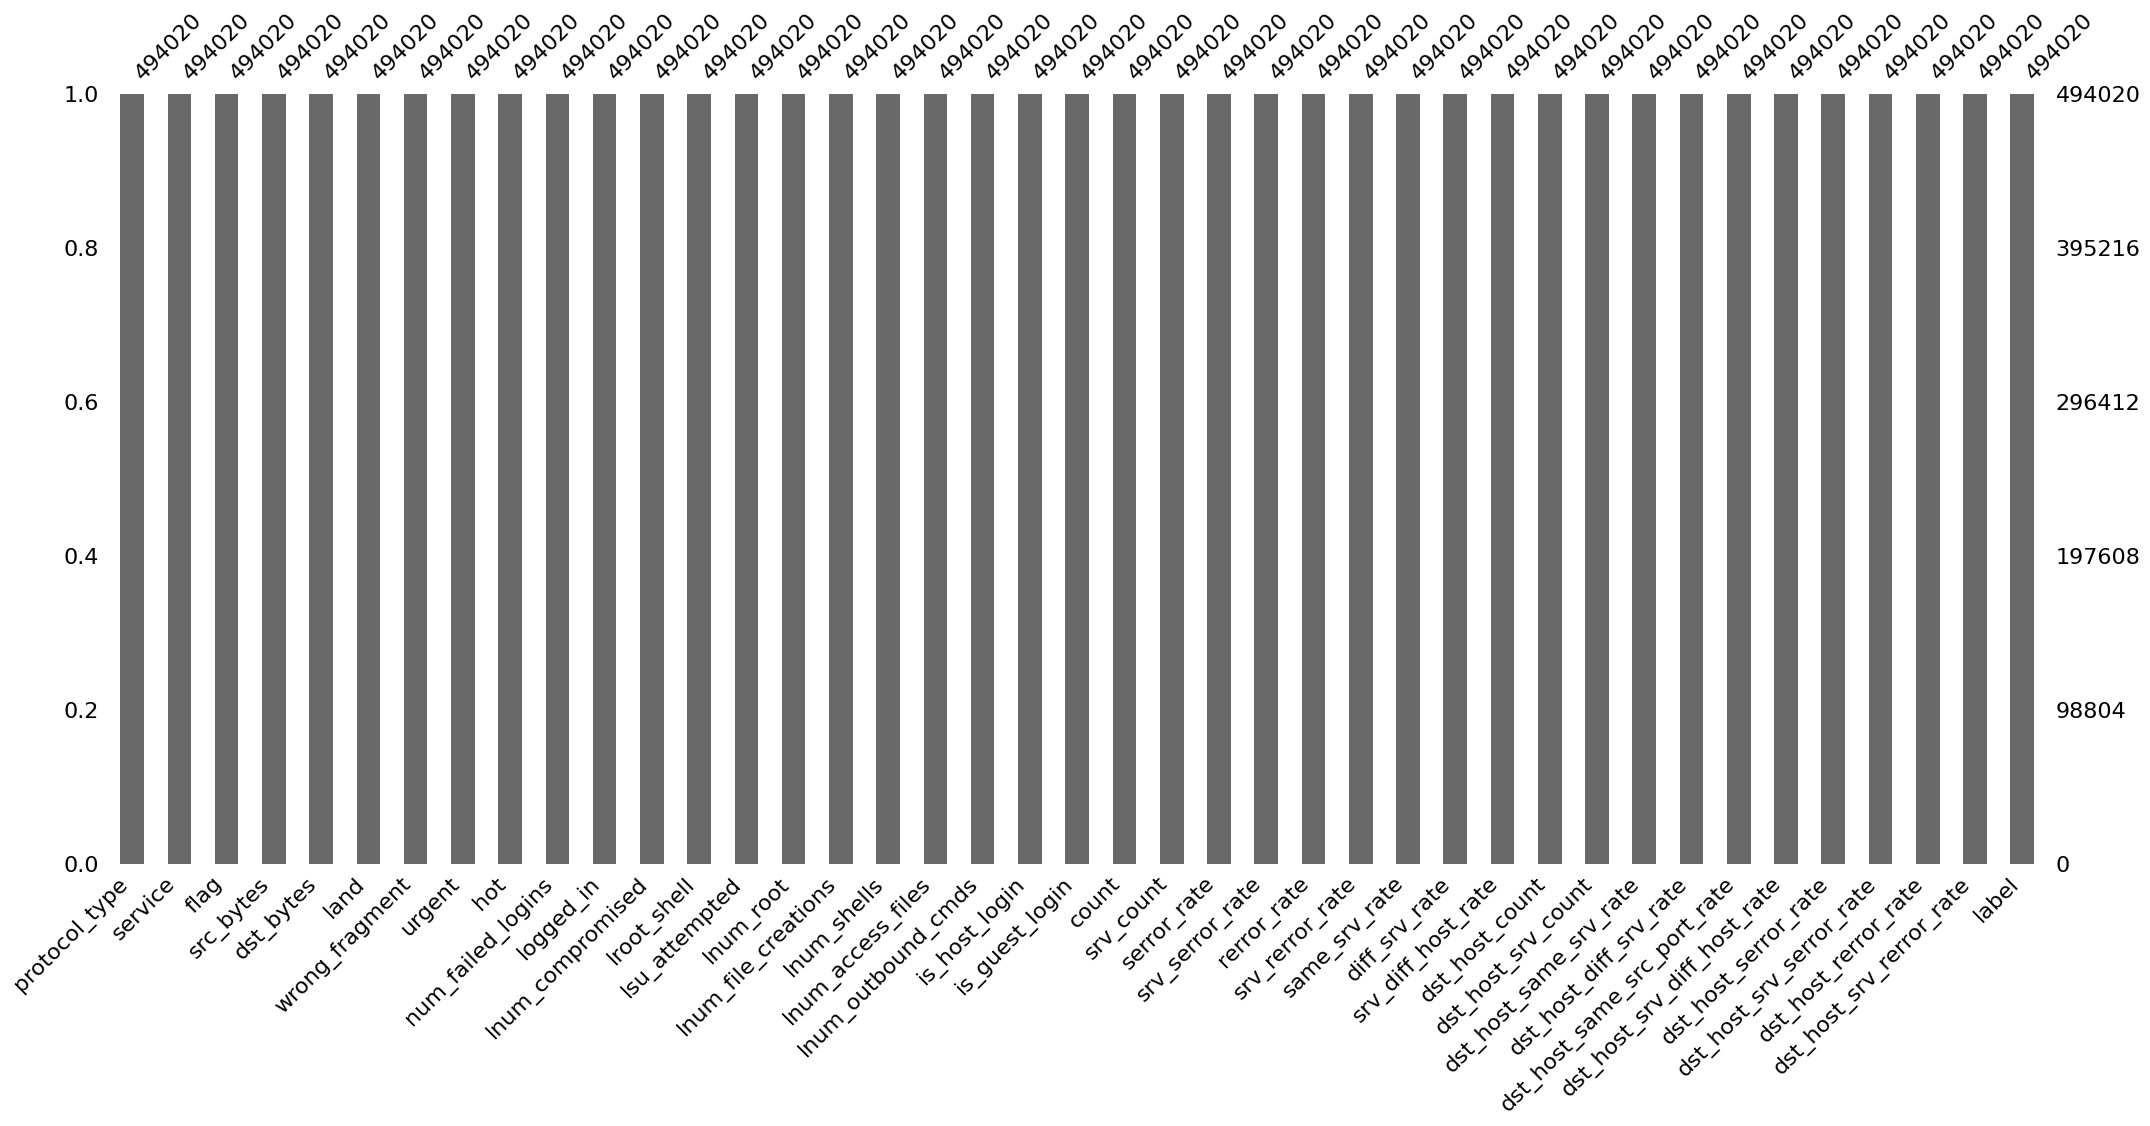

In [29]:
msno.bar(kcup_df, p=0.8, filter="top")

In [30]:
# Suppression des duplicatats
print(kcup_df.shape)
kcup_df.drop_duplicates(inplace=True)
print(kcup_df.shape)

(494020, 41)
(143670, 41)


In [31]:
# Suppression des colonnes à 1 seule valeur car pas informatif
kcup_df = kcup_df.loc[:, kcup_df.nunique() > 1].reset_index(drop=True)
kcup_df

,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,tcp,http,SF,181,5450,False,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal
1,tcp,http,SF,239,486,False,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal
2,tcp,http,SF,235,1337,False,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
3,tcp,http,SF,219,1337,False,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
4,tcp,http,SF,217,2032,False,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143665,tcp,http,SF,310,1881,False,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal
143666,tcp,http,SF,282,2286,False,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal
143667,tcp,http,SF,203,1200,False,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal
143668,tcp,http,SF,291,1200,False,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal


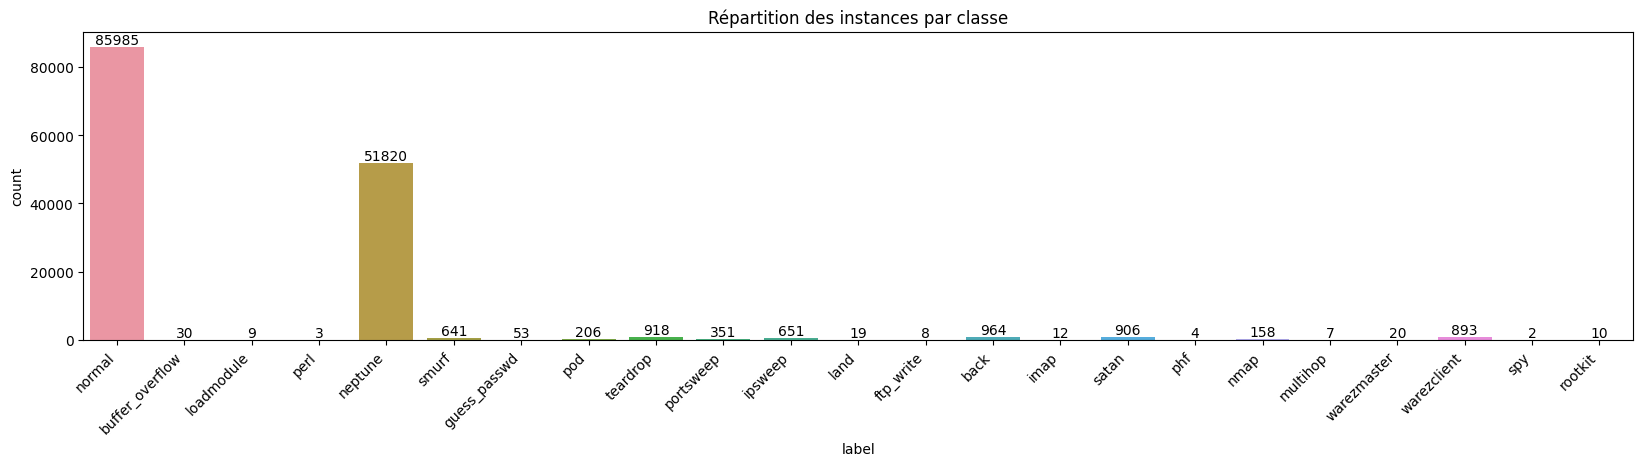

In [32]:
# Affichage de la répartition des instances par classe
plt.figure(figsize=(20, 4))
ax = sns.countplot(data=kcup_df, x="label")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), textcoords='offset points')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Répartition des instances par classe")
plt.show()

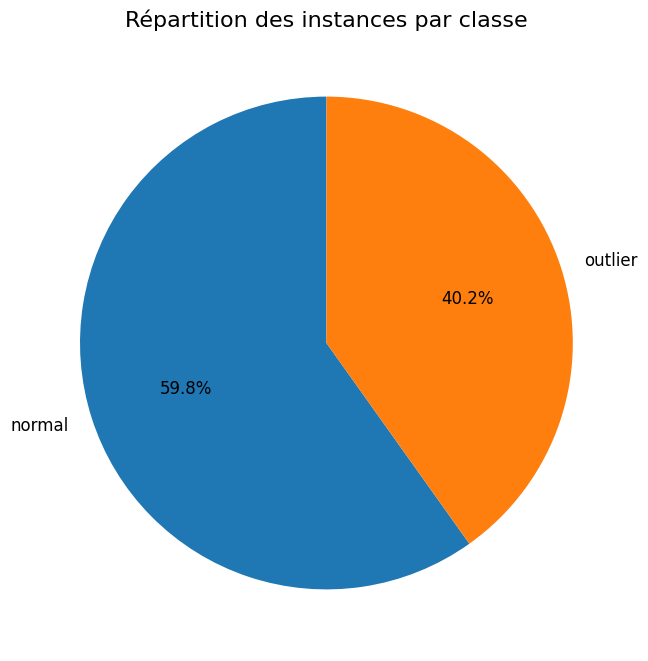

In [33]:
# Regroupement des outliers et affichage de la répartition des instances par classe
kcup_df['label'] = kcup_df['label'].apply(lambda x: 'outlier' if x != 'normal' else 'normal')

label_counts = kcup_df['label'].value_counts()
labels = label_counts.index
sizes = label_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
plt.title("Répartition des instances par classe", fontsize=16)
plt.show()

In [34]:
# Sélection des features en fonction de leur pouvoir predictif
kcup_df['label'] = [0 if value=='normal' else 1 for value in kcup_df['label']]
kcup_df['label'] = kcup_df['label'].astype("category")
pps_predictors = pps.predictors(kcup_df, y="label")
pps_predictors

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,service,label,0.925498,classification,True,weighted F1,0.524,0.964537,DecisionTreeClassifier()
1,same_srv_rate,label,0.916043,classification,True,weighted F1,0.524,0.960036,DecisionTreeClassifier()
2,src_bytes,label,0.909399,classification,True,weighted F1,0.524,0.956874,DecisionTreeClassifier()
3,diff_srv_rate,label,0.909274,classification,True,weighted F1,0.524,0.956814,DecisionTreeClassifier()
4,count,label,0.890624,classification,True,weighted F1,0.524,0.947937,DecisionTreeClassifier()
5,dst_host_same_srv_rate,label,0.863549,classification,True,weighted F1,0.524,0.935049,DecisionTreeClassifier()
6,flag,label,0.860165,classification,True,weighted F1,0.524,0.933438,DecisionTreeClassifier()
7,dst_host_diff_srv_rate,label,0.853289,classification,True,weighted F1,0.524,0.930166,DecisionTreeClassifier()
8,dst_host_srv_count,label,0.840723,classification,True,weighted F1,0.524,0.924184,DecisionTreeClassifier()
9,dst_bytes,label,0.832440,classification,True,weighted F1,0.524,0.920241,DecisionTreeClassifier()


In [35]:
# Ne conserver que les features à ppscore relevant
features = pps_predictors.loc[pps_predictors.ppscore >= 0.7]
selected_feats = features.x.to_list()
selected_feats.append("label")
selected_feats

['service',
 'same_srv_rate',
 'src_bytes',
 'diff_srv_rate',
 'count',
 'dst_host_same_srv_rate',
 'flag',
 'dst_host_diff_srv_rate',
 'dst_host_srv_count',
 'dst_bytes',
 'serror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'srv_serror_rate',
 'logged_in',
 'label']

In [36]:
# Création du dataframe final
final_df = kcup_df[selected_feats]
final_df

,service,same_srv_rate,src_bytes,diff_srv_rate,count,dst_host_same_srv_rate,flag,dst_host_diff_srv_rate,dst_host_srv_count,dst_bytes,serror_rate,dst_host_serror_rate,dst_host_srv_serror_rate,srv_serror_rate,logged_in,label
0,http,1.0,181,0.0,8,1.0,SF,0.0,9,5450,0.00,0.00,0.00,0.00,True,0
1,http,1.0,239,0.0,8,1.0,SF,0.0,19,486,0.00,0.00,0.00,0.00,True,0
2,http,1.0,235,0.0,8,1.0,SF,0.0,29,1337,0.00,0.00,0.00,0.00,True,0
3,http,1.0,219,0.0,6,1.0,SF,0.0,39,1337,0.00,0.00,0.00,0.00,True,0
4,http,1.0,217,0.0,6,1.0,SF,0.0,49,2032,0.00,0.00,0.00,0.00,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143665,http,1.0,310,0.0,4,1.0,SF,0.0,255,1881,0.00,0.00,0.01,0.00,True,0
143666,http,1.0,282,0.0,6,1.0,SF,0.0,255,2286,0.00,0.00,0.01,0.00,True,0
143667,http,1.0,203,0.0,6,1.0,SF,0.0,255,1200,0.17,0.06,0.01,0.11,True,0
143668,http,1.0,291,0.0,6,1.0,SF,0.0,255,1200,0.00,0.04,0.01,0.00,True,0


Appliquer votre méthodologie sur le jeu de données de détection d’intrusions dans les réseaux 

In [37]:
# Modèles à comparer
ESTIMATOR_PARAMS = {
    RandomForestClassifier.__name__: {
        "estimator": RandomForestClassifier,
        "params": {
            "n_estimators": [10, 50, 100, 150],
            "max_depth": [5, 10, 15],
            "min_samples_split": np.linspace(2, 10, 5, dtype=int).tolist(),
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": False,
        "oversampling": False
    },
    DecisionTreeClassifier.__name__: {
        "estimator": DecisionTreeClassifier,
        "params": {
            "max_depth": [3, 5, 10],
            "min_samples_split": np.linspace(2, 10, 5, dtype=int).tolist(),
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": False,
        "oversampling": False
    },
    IsolationForest.__name__: {
        "estimator": IsolationForest,
        "params": {
            "n_estimators": [100, 150, 200],
            "contamination": np.linspace(0.01, 0.1, 10).tolist(),
            "max_samples": [0.8, 0.9, 1.0],
            "random_state": [42]
        },
        "is_supervised": False,
        "undersampling": False,
        "oversampling": False
    },
    LocalOutlierFactor.__name__: {
        "estimator": LocalOutlierFactor,
        "params": {
            "n_neighbors": [5, 10, 20, 30],
            "contamination": np.linspace(0.01, 0.1, 10).tolist(),
            "metric": ['euclidean', 'manhattan']
        },
        "is_supervised": False,
        "undersampling": False,
        "oversampling": False
    },
    HistGradientBoostingClassifier.__name__: {
        "estimator": HistGradientBoostingClassifier,
        "params": {
            "max_iter": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 4, 5],
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "class_weight": ['balanced'],
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": False,
        "oversampling": False
    },
    RandomForestClassifier.__name__ + "_undersampled": {
        "estimator": RandomForestClassifier,
        "params": {
            "n_estimators": [10, 50, 100, 150],
            "max_depth": [5, 10, 15],
            "min_samples_split": np.linspace(2, 10, 5, dtype=int).tolist(),
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": True,
        "oversampling": False
    },
    RandomForestClassifier.__name__ + "_oversampled": {
        "estimator": RandomForestClassifier,
        "params": {
            "n_estimators": [10, 50, 100, 150],
            "max_depth": [5, 10, 15],
            "min_samples_split": np.linspace(2, 10, 5, dtype=int).tolist(),
            "min_samples_leaf": np.linspace(1, 5, 5, dtype=int).tolist(),
            "random_state": [42]
        },
        "is_supervised": True,
        "undersampling": False,
        "oversampling": True
    },
}

Demarrage recherche hyperparametres pour RandomForestClassifier
Done! Meilleurs hyperparamètres pour RandomForestClassifier {'random_state': 42, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}
Performance du meilleur modele: RandomForestClassifier
Mean AUC ROC: 1.00
Mean AUC PR: 1.00
Mean F1 Score: 1.00
Mean Balanced Acc: 1.00
Demarrage recherche hyperparametres pour DecisionTreeClassifier
Done! Meilleurs hyperparamètres pour DecisionTreeClassifier {'random_state': 42, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 10}
Performance du meilleur modele: DecisionTreeClassifier
Mean AUC ROC: 1.00
Mean AUC PR: 1.00
Mean F1 Score: 1.00
Mean Balanced Acc: 1.00
Demarrage recherche hyperparametres pour IsolationForest
Done! Meilleurs hyperparamètres pour IsolationForest {'random_state': 42, 'n_estimators': 100, 'max_samples': 0.8, 'contamination': 0.01}
Performance du meilleur modele: IsolationForest
Mean AUC ROC: 0.75
Mean AUC PR: 0.87
Mean F1 S

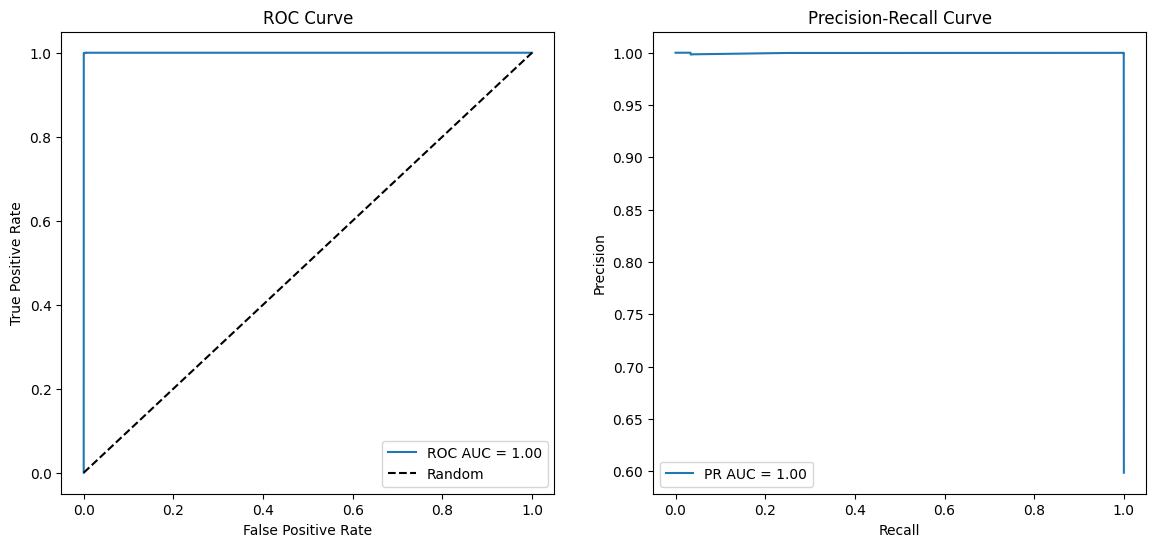

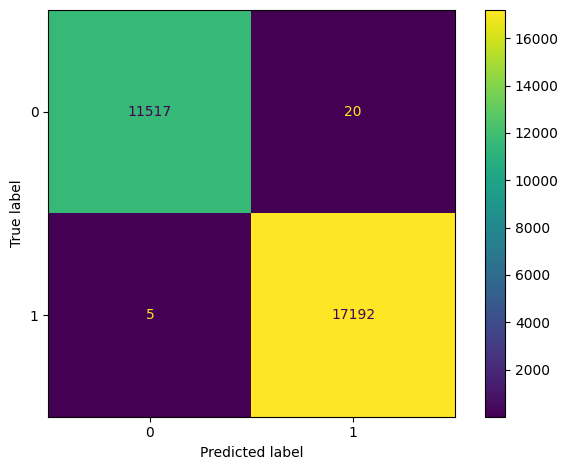

In [38]:
# Run de l'automatisation et résultats
compare_models_anomaly(final_df, 'label', ESTIMATOR_PARAMS)

#### Méthodologie pour la détection de nouveautés

In [39]:

ESTIMATOR_PARAMS = {
    IsolationForest.__name__: {
        "estimator": IsolationForest,
        "params": {
            "n_estimators": [100, 150, 200],
            "contamination": np.linspace(0.01, 0.1, 10).tolist(),
            "max_samples": [0.8, 0.9, 1.0],
            "random_state": [42]
        }
    },
    LocalOutlierFactor.__name__: {
        "estimator": LocalOutlierFactor,
        "params": {
            "n_neighbors": [5, 10, 20, 30],
            "contamination": np.linspace(0.01, 0.1, 10).tolist(),
            "metric": ['euclidean', 'manhattan'],
            "novelty": [True] 
        }
    }
}


Demarrage recherche hyperparametres pour IsolationForest
Meilleurs hyperparamètres pour IsolationForest : {'n_estimators': 100, 'contamination': 0.1, 'max_samples': 1.0, 'random_state': 42}
Performance du meilleur modele: IsolationForest
AUC ROC: 0.74
AUC PR: 0.86
F1 Score: 0.74
Balanced Acc: 0.53
Demarrage recherche hyperparametres pour LocalOutlierFactor
Meilleurs hyperparamètres pour LocalOutlierFactor : {'n_neighbors': 10, 'contamination': 0.030000000000000006, 'metric': 'euclidean', 'novelty': True}
Performance du meilleur modele: LocalOutlierFactor
AUC ROC: 0.98
AUC PR: 0.99
F1 Score: 0.94
Balanced Acc: 0.92
---------------------------------- FINAL RESULTS ------------------------------------------
Meilleur modele trouvé après comparaison des approches: LocalOutlierFactor
ROC AUC Score: 0.99
Average Precision Score: 0.99
F1 Score: 0.94
Balanced Acc: 0.9131087119380763


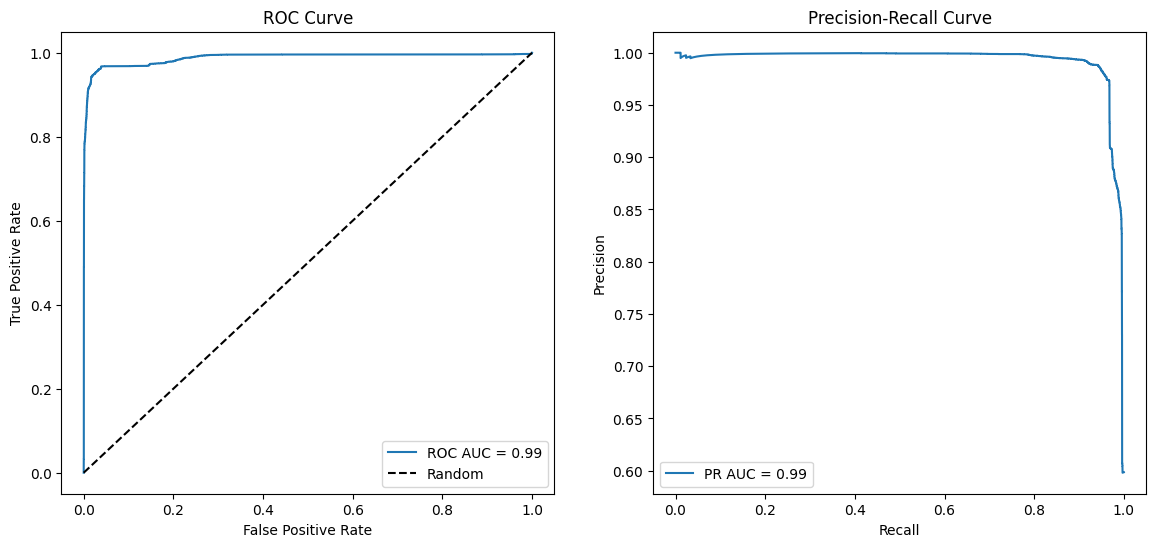

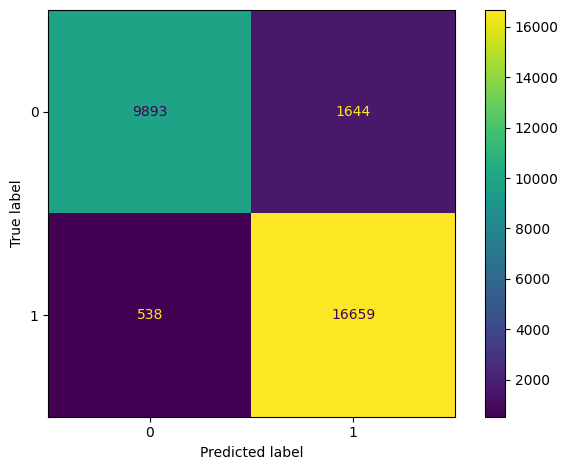

In [40]:
# Run de l'automatisation et résultats
compare_models_novelty(final_df, 'label', ESTIMATOR_PARAMS, compare_with='auc_pr')